In [26]:
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt
import math
from scipy.ndimage import gaussian_filter
from scipy import ndimage

In [5]:
def draw_edge_attributes(image, attribute_list):
    attributed_image = image.copy()
    for lines in attribute_list:
        for line in lines:
            angle = (float)(line["angle"])
            distance = (float)(line["distance"])

            a = np.cos(angle)
            b = np.sin(angle)
            x0 = a * distance
            y0 = b * distance
            pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
            pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))

            cv2.line(
                attributed_image,
                pt1,
                pt2,
                (0, 255, 0),
                2,
            )

    return attributed_image
def binarize(gray_image, thresh_val):
    """ Function to threshold grayscale image to binary
        Sets all pixels lower than threshold to 0, else 255

        Args:
        - gray_image: grayscale image as an array
        - thresh_val: threshold value to compare brightness with

        Return:
        - binary_image: the thresholded image
    """
    # TODO: 255 if intensity >= thresh_val else 0
    
    binary_image = np.zeros((gray_image.shape) , dtype = np.uint8 )
    binary_image[ gray_image >= thresh_val ] = 255

    return binary_image

def label(binary_image):
    """ Function to labeled components in a binary image
        Uses a sequential labeling algorithm

        Args:
        - binary_image: binary image with multiple components to label

        Return:
        - lab_im: binary image with grayscale level as label of component
    """

    _ , lab_im = cv2.connectedComponents(binary_image, connectivity=4, ltype=cv2.CV_32S)
    lab_im = lab_im / np.max(lab_im)
    lab_im = np.uint8( lab_im * 255 )
    #plt.imshow(lab_im , cmap = 'gray')
    return lab_im

def swap(t1, t2):
    return t2, t1

def get_attribute(labeled_image):
    """ Function to get the attributes of each component of the image
        Calculates the position, orientation, and roundedness

        Args:
        - labeled_image: image file with labeled components

        Return:
        - attribute_list: a list of the aforementioned attributes
    """
    # TODO
    labels = np.unique(labeled_image)
    tmp_image = labeled_image.copy()
    attribute_list = []
    #vec = np.array([1,2,3,4])
    #vec = vec*vec
    #print(vec)
    for i in range(1,len(labels)):
        #calculate position
        cols , rows = np.where(labeled_image == labels[i] )
        center_x = int(np.around( np.average(rows) )) 
        center_y = int(np.around( np.average(cols) )) 
        a = np.sum( (rows - center_x)**2 )
        b = 2 * np.sum((cols - center_y)*(rows - center_x) )
        c = np.sum( (cols - center_y)**2 )
        
        theta1 = np.arctan(1.0* b / (a-c) ) / 2.0
        theta2 = theta1 + math.pi/2
        if(theta2 > math.pi):
            theta2 = theta2 - math.pi
        if(theta1 > theta2):
            swap(theta1,theta2)
            
        theta_min = theta1
        theta_max = theta2
        if(  (a-c)*math.cos(2*theta_min) + b*math.sin(2*theta_min) <0 ):
            swap(theta_max , theta_min)
        E_min = a * (math.sin(theta_min)**2) - b * (math.sin(theta_min) *math.cos(theta_min)) + c * (math.cos(theta_min)**2)
        E_max = a * (math.sin(theta_max)**2) - b * (math.sin(theta_max) *math.cos(theta_max)) + c * (math.cos(theta_max)**2)
        attribute = {'position': {'x':center_x , 'y': labeled_image.shape[0] - center_y }, 'orientation': theta_min, 'roundedness': E_min / E_max}
        attribute_list.append(attribute)
    return attribute_list

def draw_attributes(image, attribute_list):
    num_row = image.shape[0]
    attributed_image = image.copy()
    for attribute in attribute_list:
        center_x = (int)(attribute["position"]["x"])
        center_y = (int)(attribute["position"]["y"])
        slope = np.tan(attribute["orientation"])
        
        cv2.circle(attributed_image, (center_x, num_row - center_y), 2, (0, 255, 0), 2)
        cv2.line(
                    attributed_image,
                    (center_x, num_row - center_y),
                    (center_x + 20, int(20 * (-slope) + num_row - center_y)),
                    (0, 255, 0),
                    2,
                )
        cv2.line(
                    attributed_image,
                    (center_x, num_row - center_y),
                    (center_x - 20, int(-20 * (-slope) + num_row - center_y)),
                    (0, 255, 0),
                    2,
                )
    plt.imshow(attributed_image)
        
    return attributed_image



def detect_edges(image, sigma, threshold):
    """Find edge points in a grayscale image.

      Args:
      - image (2D uint8 array): A grayscale image.

      Return:
        - edge_image (2D binary image): each location indicates whether it belongs to an edge or not
    """

    filter_size = 5
    ############################################################################
    tmp_image =  gaussian_filter(image, sigma = sigma ) 
    sobel_x = cv2.Sobel(tmp_image, cv2.CV_64F, 1, 0, ksize = filter_size)
    sobel_x = sobel_x * sobel_x
    
    sobel_y = cv2.Sobel(tmp_image, cv2.CV_64F, 0, 1, ksize = filter_size)
    sobel_y = sobel_y * sobel_y
    
    grad_mag = np.sqrt(sobel_x + sobel_y)
    ############################################################################
    edge_image = image.copy()
    edge_image[grad_mag >= threshold] = 255
    edge_image[grad_mag < threshold] = 0
    plt.imshow(grad_mag ,cmap = 'gray')
    return edge_image

attribute list:
[{'position': {'x': 349, 'y': 216}, 'orientation': -0.310501186336796, 'roundedness': 1.8733999106242403}, {'position': {'x': 195, 'y': 223}, 'orientation': -0.68778479202829, 'roundedness': 0.4796816423240838}]


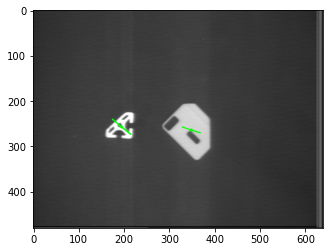

In [25]:
  #img_name = argv[0]
if( True ):
    img_name = 'two_objects'
  #thresh_val = int(argv[1])
    thresh_val = 128
    img = cv2.imread('data/' + img_name + '.png', cv2.IMREAD_COLOR)

    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite('output/' + img_name + "_gray.png", gray_image)

  # part 1
    binary_image = binarize(gray_image, thresh_val = thresh_val)
    cv2.imwrite('output/' + img_name + "_binary.png", binary_image)
  

    labeled_image = label(binary_image)
    cv2.imwrite('output/' + img_name + "_labeled.png", labeled_image)

    attribute_list = get_attribute(labeled_image)
    print('attribute list:')
    print(attribute_list)

    attributed_image = draw_attributes(img, attribute_list)
    cv2.imwrite("output/" + img_name + "_attributes.png", attributed_image)

In [35]:
def get_edge_attribute(labeled_image, edge_image):
    '''
      Function to get the attributes of each edge of the image
            Calculates the angle, distance from the origin and length in pixels
      Args:
        labeled_image: binary image with grayscale level as label of component
        edge_image (2D binary image): each location indicates whether it belongs to an edge or not

      Returns:
         attribute_list: a list of list [[dict()]]. For example, [lines1, lines2,...],
         where lines1 is a list and it contains lines for the first object of attribute_list in part 1.
         Each item of lines 1 is a line, i.e., a dictionary containing keys with angle, distance, length.
         You should associate objects in part 1 and lines in part 2 by putting the attribute lists in same order.
         Note that votes in HoughLines opencv-python is not longer available since 2015. You will need to compute the length yourself.
    '''
  # TODO
    attribute_list = []
    labels = np.unique(labeled_image)
    
    for i in range(1,len(labels)):
        
        #positions
        cols , rows = np.where(labeled_image == labels[i])
        print(len(cols))
        #initialization
        lines = []
        theta_max = math.pi/2
        theta_min = -math.pi/2
        rho_max = 300.0
        rho_min = -300.0
        rho_dim = 600 
        theta_dim = 360
        hough_space = np.zeros((rho_dim,theta_dim))
        
        #hough space vate
        for i in range(len(cols)):
            y = cols[i]
            x = rows[i]
            if(edge_image[x][y] != 255):
                continue;
            for itheta in range(theta_dim):
                theta = theta_min + (1.0 * itheta * math.pi / theta_dim)
                rho = y * math.cos(theta) - x * math.sin(theta)
                irho = rho - rho_min
                if(irho < 600 and irho >= 0) :
                    hough_space[int(irho),itheta] = hough_space[int(irho),itheta] + 1
                    
        image = hough_space

        image_max = ndimage.maximum_filter(hough_space, size=7, mode='constant')
        mask = (image == image_max)
        image *= mask

        # Remove the image borders
        image[:3] = 0
        image[-3:] = 0
        image[:, :3] = 0
        image[:, -3:] = 0

        # Find peaks above some threshold
        image_t = (image > 60) * 1

        # get coordinates of peaks
        f = np.transpose(image_t.nonzero())

        #print(f)
        tmp_image = labeled_image.copy()
        temp= np.zeros(edge_image.shape,dtype = np.uint8)
        for parameters in f:
            [i, j] = parameters
          # Compute the real rho and theta parameters given the index in the hough space
            rho = i - 300.0
            theta = theta_min + (1.0 * j * math.pi / theta_dim)

          # Draw the lines here - you may need to compute x, y values for each line to be able to use cv2.line to draw them!
            y1 = 0
            y2 = 400
            x1 = int((rho+(y1*math.sin(theta)))/math.cos(theta))
            x2 = int((rho+(y2*math.sin(theta)))/math.cos(theta))
            image = cv2.line(temp, (x1,y1), (x2,y2), (255,255,255), 1)
       # plt.figure(figsize=(12,8))
        #plt.imshow(temp,cmap='gray')
        #plt.show()
        #attribute_list.append(lines)
    return attribute_list

7649


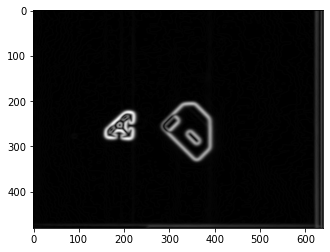

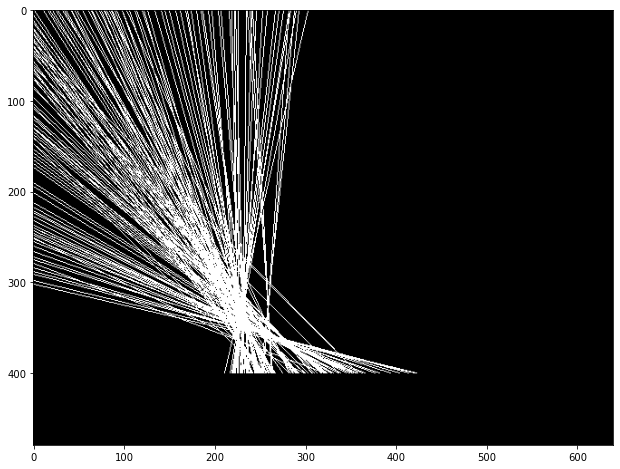

2044


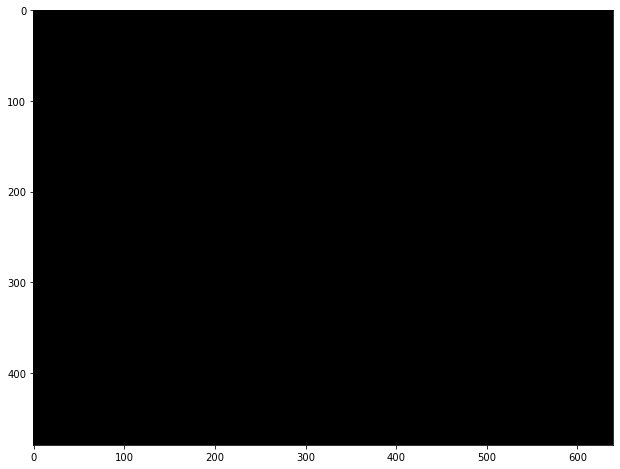

In [36]:
 # part 2
  # feel free to tune hyperparameters or use double-threshold
if(True):
    edge_image = detect_edges(gray_image, sigma=3., threshold=0.3)
    cv2.imwrite("output/" + img_name + "_edges.png", edge_image)

    edge_attribute_list = get_edge_attribute(labeled_image, edge_image)
    #print('edge attribute list:')
    #print(edge_attribute_list)

    #attributed_edge_image = draw_attributes(img, edge_attribute_list)
    #cv2.imwrite("output/" + img_name + "_edge_attributes.png", attributed_edge_image)

  # extra credits for part 2: show your circle attributes and plot circles
    '''
    circle_attribute_list = get_circle_attribute(labeled_image, edge_image)
    attributed_circle_image = draw_circle_attributes(img, circle_attribute_list)
    cv2.imwrite("output/" + img_name + "_circle_attributes.png", attributed_circle_image)
    '''
  # part 3
    '''
    
    objects = detect_objects(attribute_list, edge_attribute_list)
    print(objects)
    '''